In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
from fair import FAIR
from fair.io import read_properties
from fair.interface import fill
from fair.io import read_properties
from fair.interface import initialise


1. Initialise FaIR

In [3]:
f_inhaled = FAIR()

2. Define time horizon

In [4]:
f_inhaled.define_time(1750, 2500, 1)

3. Define scenarios

In [5]:
# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = ["ssp119", "ssp245", "ssp585"]
f_inhaled.define_scenarios(scenarios)

4. Define configs

In [6]:
# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_inhaled.define_configs(configs)

5. Define species and properties

In [7]:
species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_inhaled.define_species(species, properties)

6. Modify run options (optional)

7. Initialise arrays

In [8]:
f_inhaled.allocate()

8. Fill in data

In [9]:
f_inhaled.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

In [10]:
# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_inhaled.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

In [11]:
# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions.csv")

In [12]:
# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1 = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1 = emissions_1[:, :, np.newaxis]
emissions_1 = np.repeat(emissions_1, len(configs), axis=2)

In [13]:
species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2 = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2 = emissions_2[:, :, np.newaxis]
emissions_2 = np.repeat(emissions_2, len(configs), axis=2)

In [14]:
species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3 = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3 = emissions_3[:, :, np.newaxis]
emissions_3 = np.repeat(emissions_3, len(configs), axis=2)

In [15]:
species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4 = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4 = emissions_4[:, :, np.newaxis]
emissions_4 = np.repeat(emissions_4, len(configs), axis=2)

In [16]:
fill(f_inhaled.emissions, emissions_1, specie="HFE-236ea2")
fill(f_inhaled.emissions, emissions_2, specie="HFE-347mmz1")
fill(f_inhaled.emissions, emissions_3, specie="HCFE-235da2")
fill(f_inhaled.emissions, emissions_4, specie="Halon-2311")

In [17]:
# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40000000 interventions per annum * 0.5 kg of plastic per interventions * 3 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 6e-5 GtCO2
TIVA_emissions_hist = np.zeros(750)
TIVA_emissions_hist[250:275] = 6e-5

f_inhaled.emissions.loc[dict(specie='CO2 FFI')] = f_inhaled.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_hist[:, np.newaxis, np.newaxis]

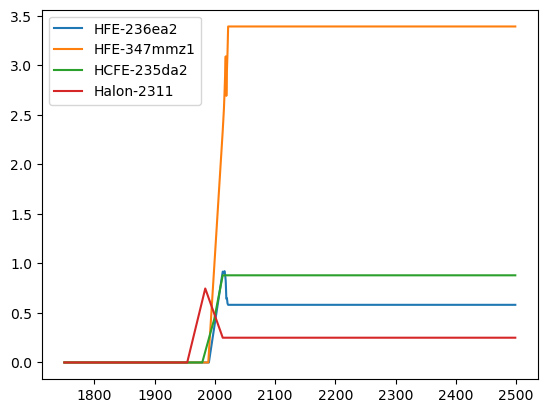

In [18]:
# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
plt.plot(timebounds, emissions_1[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4[:, 0, 0], label="Halon-2311")
plt.legend()
plt.show()

8a. Fill in data - species configs

In [19]:
f_inhaled.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

8b. Fill in data - emissions

In [20]:
# initialising 
initialise(f_inhaled.concentration, f_inhaled.species_configs["baseline_concentration"])
initialise(f_inhaled.forcing, 0)
initialise(f_inhaled.temperature, 0)
initialise(f_inhaled.cumulative_emissions, 0)
initialise(f_inhaled.airborne_emissions, 0)

8c. Fill in data - climate configs

In [21]:

f_inhaled.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

9 Run FaIR

In [22]:
f_inhaled.run()

Running 2523 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

In [23]:
# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_inhaled_temperature = f_inhaled.temperature[:,:,:,0].copy(deep=True)
del f_inhaled

10 Pretty plots!

In [24]:
# Run twin experiment, but for an abrupt change to TIVA interventions
# The scenario assumption is an abrupt change of type of anaesthesia from inhaled to TIVA types,
# where emissions from inhaled species go to 0 in 2025 and TIVA-related emissions of CO2 go to 0.00045 GtC/year.
# Note that overwriting the data for the inhaled anaesthesics is necessary because the data file we are currently using has the wrong data
# TODO: We should probably update ssp_emissions_1750-2500.nc file at some point to have this data directly
f_tiva_abrupt_change = FAIR()
f_tiva_abrupt_change.define_time(1750, 2500, 1)
f_tiva_abrupt_change.define_scenarios(scenarios)
f_tiva_abrupt_change.define_configs(configs)
species_tiva_abrupt_change, properties_tiva_abrupt_change = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_tiva_abrupt_change.define_species(species_tiva_abrupt_change, properties_tiva_abrupt_change)
f_tiva_abrupt_change.allocate()
f_tiva_abrupt_change.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)]
fe = da.expand_dims(dim=["config"], axis=(2))
f_tiva_abrupt_change.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Load inhaled emissions, but set them at 0 after 2025
# Prepare the new emissions
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions.csv")

species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_tiva_abrupt_change = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_tiva_abrupt_change[275:, :] = 0
emissions_1_tiva_abrupt_change = emissions_1_tiva_abrupt_change[:, :, np.newaxis]
emissions_1_tiva_abrupt_change = np.repeat(emissions_1_tiva_abrupt_change, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_tiva_abrupt_change = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_tiva_abrupt_change[275:, :] = 0
emissions_2_tiva_abrupt_change = emissions_2_tiva_abrupt_change[:, :, np.newaxis]
emissions_2_tiva_abrupt_change = np.repeat(emissions_2_tiva_abrupt_change, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_tiva_abrupt_change = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_tiva_abrupt_change[275:, :] = 0
emissions_3_tiva_abrupt_change = emissions_3_tiva_abrupt_change[:, :, np.newaxis]
emissions_3_tiva_abrupt_change = np.repeat(emissions_3_tiva_abrupt_change, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_tiva_abrupt_change = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_tiva_abrupt_change[275:, :] = 0
emissions_4_tiva_abrupt_change = emissions_4_tiva_abrupt_change[:, :, np.newaxis]
emissions_4_tiva_abrupt_change = np.repeat(emissions_4_tiva_abrupt_change, len(configs), axis=2)

fill(f_tiva_abrupt_change.emissions, emissions_1_tiva_abrupt_change, specie="HFE-236ea2")
fill(f_tiva_abrupt_change.emissions, emissions_2_tiva_abrupt_change, specie="HFE-347mmz1")
fill(f_tiva_abrupt_change.emissions, emissions_3_tiva_abrupt_change, specie="HCFE-235da2")
fill(f_tiva_abrupt_change.emissions, emissions_4_tiva_abrupt_change, specie="Halon-2311")

# Add TIVA:
# 0.5 kg of plastic waster per intervention * 300 millions of interventions = 150 millions Kg of plastic waster
# ~3 Kg of CO2 emissions per Kg of plastic waster burned * 150 millions of kg of plastic waste = 450 millions of CO2 = 0.00045 GtC
TIVA_emissions = np.zeros(750)
TIVA_emissions[275:] = 4.5 * 0.0001

f_tiva_abrupt_change.emissions.loc[dict(specie='CO2 FFI')] = f_tiva_abrupt_change.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions[:, np.newaxis, np.newaxis] + TIVA_emissions_hist[:, np.newaxis, np.newaxis]

f_tiva_abrupt_change.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
initialise(f_tiva_abrupt_change.concentration, f_tiva_abrupt_change.species_configs["baseline_concentration"])
initialise(f_tiva_abrupt_change.forcing, 0)
initialise(f_tiva_abrupt_change.temperature, 0)
initialise(f_tiva_abrupt_change.cumulative_emissions, 0)
initialise(f_tiva_abrupt_change.airborne_emissions, 0)
f_tiva_abrupt_change.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_tiva_abrupt_change.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_tiva_abrupt_change_temperature = f_tiva_abrupt_change.temperature[:,:,:,0].copy(deep=True)
del f_tiva_abrupt_change

Running 2523 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

In [25]:
# Run twin experiment, to calculate only contribution of TIVA-related emissions
# Essentially, this is the same as the reference run (no anaesthesics) but with extra CO2 emissions
f_tiva_only = FAIR()
f_tiva_only.define_time(1750, 2500, 1)
f_tiva_only.define_scenarios(scenarios)
f_tiva_only.define_configs(configs)
species_no_anaesthesics, properties_no_anaesthesics = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_original.csv")
f_tiva_only.define_species(species_no_anaesthesics, properties_no_anaesthesics)
f_tiva_only.allocate()
f_tiva_only.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)]
fe = da.expand_dims(dim=["config"], axis=(2))
f_tiva_only.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Add TIVA:
# 0.5 kg of plastic waster per intervention * 300 millions of interventions = 150 millions Kg of plastic waster
# ~3 Kg of CO2 emissions per Kg of plastic waster burned * 150 millions of kg of plastic waste = 450 millions of CO2 = 0.00045 GtC
TIVA_emissions = np.zeros(750)
TIVA_emissions[275:] = 4.5 * 0.0001
# Also add historical emissions

f_tiva_only.emissions.loc[dict(specie='CO2 FFI')] = f_tiva_only.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions[:, np.newaxis, np.newaxis] + TIVA_emissions_hist[:, np.newaxis, np.newaxis]

f_tiva_only.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
initialise(f_tiva_only.concentration, f_tiva_only.species_configs["baseline_concentration"])
initialise(f_tiva_only.forcing, 0)
initialise(f_tiva_only.temperature, 0)
initialise(f_tiva_only.cumulative_emissions, 0)
initialise(f_tiva_only.airborne_emissions, 0)
f_tiva_only.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0.csv')

f_tiva_only.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_tiva_only_temperature = f_tiva_only.temperature[:,:,:,0].copy(deep=True)
del f_tiva_only

Running 2523 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

In [26]:
# Run twin experiment, but without anesthesics
f_no_anesthesics = FAIR()
f_no_anesthesics.define_time(1750, 2500, 1)
f_no_anesthesics.define_scenarios(scenarios)
f_no_anesthesics.define_configs(configs)
species_no_anaesthesics, properties_no_anaesthesics = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_original.csv")
f_no_anesthesics.define_species(species_no_anaesthesics, properties_no_anaesthesics)
f_no_anesthesics.allocate()
f_no_anesthesics.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)]
fe = da.expand_dims(dim=["config"], axis=(2))
f_no_anesthesics.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))
f_no_anesthesics.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
initialise(f_no_anesthesics.concentration, f_no_anesthesics.species_configs["baseline_concentration"])
initialise(f_no_anesthesics.forcing, 0)
initialise(f_no_anesthesics.temperature, 0)
initialise(f_no_anesthesics.cumulative_emissions, 0)
initialise(f_no_anesthesics.airborne_emissions, 0)
f_no_anesthesics.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0.csv')

f_no_anesthesics.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_no_anesthesics_temperature = f_no_anesthesics.temperature[:,:,:,0].copy(deep=True)
del f_no_anesthesics

Running 2523 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

In [27]:
# Calculate temperature anomaly differences between experiments
scenario_to_compare = "ssp245"
temp_ano_inhaled_vs_reference = f_inhaled_temperature.loc[dict(scenario=scenario_to_compare)] - f_no_anesthesics_temperature.loc[dict(scenario=scenario_to_compare)]
temp_ano_tiva_abrupt_change_vs_reference = f_tiva_abrupt_change_temperature.loc[dict(scenario=scenario_to_compare)] - f_no_anesthesics_temperature.loc[dict(scenario=scenario_to_compare)]
temp_ano_tiva_abrupt_change_vs_inhaled = f_tiva_abrupt_change_temperature.loc[dict(scenario=scenario_to_compare)] - f_inhaled_temperature.loc[dict(scenario=scenario_to_compare)]
temp_ano_tiva_only_vs_reference = f_tiva_only_temperature.loc[dict(scenario=scenario_to_compare)] - f_no_anesthesics_temperature.loc[dict(scenario=scenario_to_compare)]

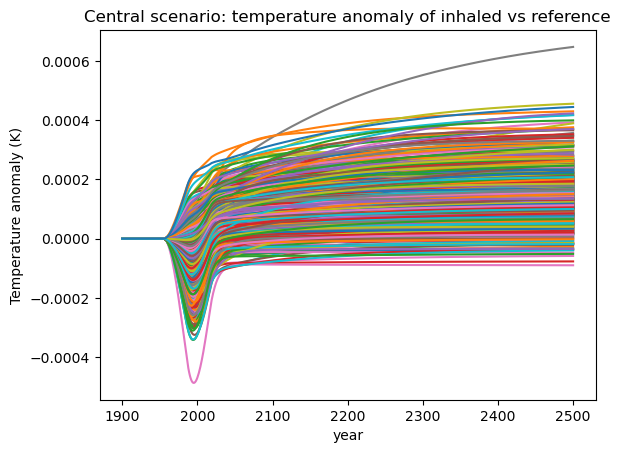

In [28]:
simulation_timebounds = np.arange(1750,2501,1)

plt.plot(simulation_timebounds[150:], temp_ano_inhaled_vs_reference[150:])
plt.title('Central scenario: temperature anomaly of inhaled vs reference')
plt.xlabel('year')
plt.ylabel('Temperature anomaly (K)')
plt.show()

Same plot with standard deviation, rather than simply all the projections printed to screen

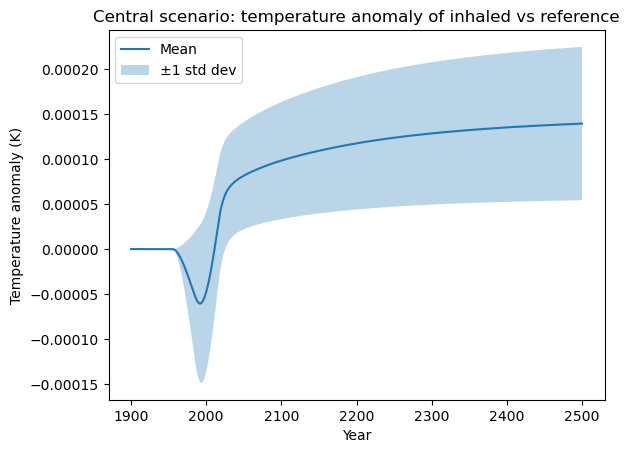

In [29]:
# Slice the relevant part of the data
time_inhaled = simulation_timebounds[150:]
temp_inhaled = temp_ano_inhaled_vs_reference[150:]

# Compute mean and standard deviation over 'config'
mean_temp_inhaled = temp_inhaled.mean(dim='config')
std_temp_inhaled = temp_inhaled.std(dim='config')

# Convert to numpy for plotting
time_np_inhaled = time_inhaled
mean_np_inhaled = mean_temp_inhaled.values
std_np_inhaled = std_temp_inhaled.values

# Plot the mean with a shaded area for ±1 std dev
plt.plot(time_np_inhaled, mean_np_inhaled, label='Mean')
plt.fill_between(time_np_inhaled, mean_np_inhaled - std_np_inhaled, mean_np_inhaled + std_np_inhaled, alpha=0.3, label='±1 std dev')

plt.title('Central scenario: temperature anomaly of inhaled vs reference')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()

5-95th percentiles

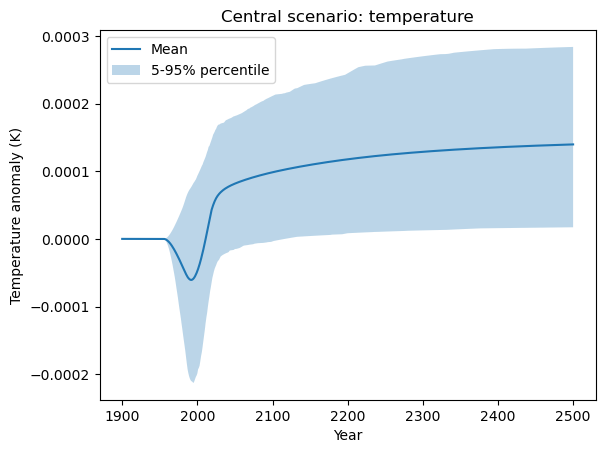

In [30]:
p05_inhaled = temp_inhaled.quantile(0.05, dim='config')
p95_inhaled = temp_inhaled.quantile(0.95, dim='config')

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(time_np_inhaled, mean_np_inhaled, label='Mean')
plt.fill_between(time_np_inhaled, p05_inhaled, p95_inhaled, alpha=0.3, label='5-95% percentile')

plt.title('Central scenario: temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()

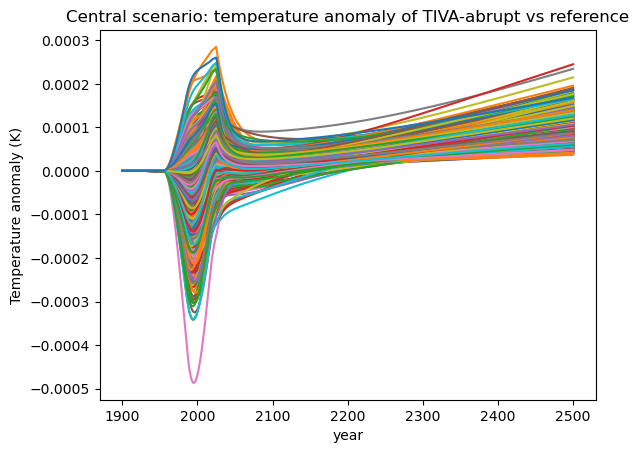

In [31]:
# Same plots as before but for T

plt.plot(simulation_timebounds[150:], temp_ano_tiva_abrupt_change_vs_reference[150:])
plt.title('Central scenario: temperature anomaly of TIVA-abrupt vs reference')
plt.xlabel('year')
plt.ylabel('Temperature anomaly (K)')
plt.show()

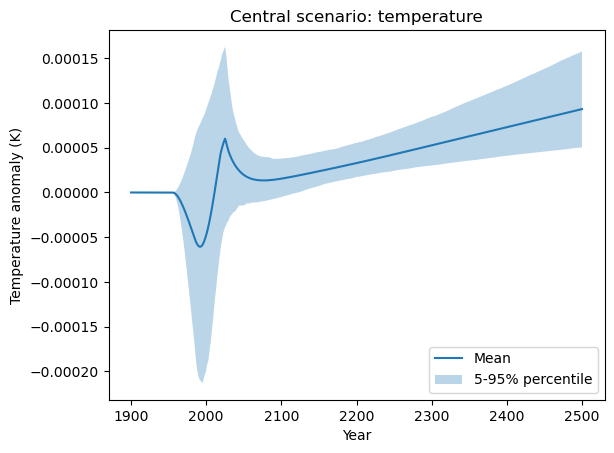

In [32]:
# Slice the relevant part of the data
time_tiva_abrupt_change = simulation_timebounds[150:]
temp_tiva_abrupt_change = temp_ano_tiva_abrupt_change_vs_reference[150:]

# Compute mean and standard deviation over 'config'
mean_temp_tiva_abrupt_change = temp_tiva_abrupt_change.mean(dim='config')
std_temp_tiva_abrupt_change = temp_tiva_abrupt_change.std(dim='config')

# Convert to numpy for plotting
time_np_tiva_abrupt_change = time_tiva_abrupt_change
mean_np_tiva_abrupt_change = mean_temp_tiva_abrupt_change.values
std_np_tiva_abrupt_change = std_temp_tiva_abrupt_change.values

p05_tiva_abrupt_change = temp_tiva_abrupt_change.quantile(0.05, dim='config')
p95_tiva_abrupt_change = temp_tiva_abrupt_change.quantile(0.95, dim='config')


# Plot the mean with a shaded area for 5-95 percentile
plt.plot(time_np_tiva_abrupt_change, mean_np_tiva_abrupt_change, label='Mean')
plt.fill_between(time_np_tiva_abrupt_change, p05_tiva_abrupt_change, p95_tiva_abrupt_change, alpha=0.3, label='5-95% percentile')

plt.title('Central scenario: temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()

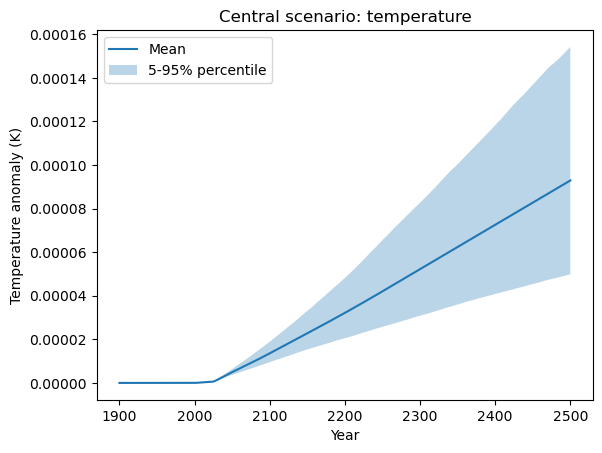

In [33]:
# Slice the relevant part of the data
time_tiva_only = simulation_timebounds[150:]
temp_tiva_only = temp_ano_tiva_only_vs_reference[150:]

# Compute mean and standard deviation over 'config'
mean_temp_tiva_only = temp_tiva_only.mean(dim='config')
std_temp_tiva_only = temp_tiva_only.std(dim='config')

# Convert to numpy for plotting
time_np_tiva_only = time_tiva_only
mean_np_tiva_only = mean_temp_tiva_only.values
std_np_tiva_only = std_temp_tiva_only.values

p05_tiva_only = temp_tiva_only.quantile(0.05, dim='config')
p95_tiva_only = temp_tiva_only.quantile(0.95, dim='config')


# Plot the mean with a shaded area for 5-95 percentile
plt.plot(time_np_tiva_only, mean_np_tiva_only, label='Mean')
plt.fill_between(time_np_tiva_only, p05_tiva_only, p95_tiva_only, alpha=0.3, label='5-95% percentile')

plt.title('Central scenario: temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()

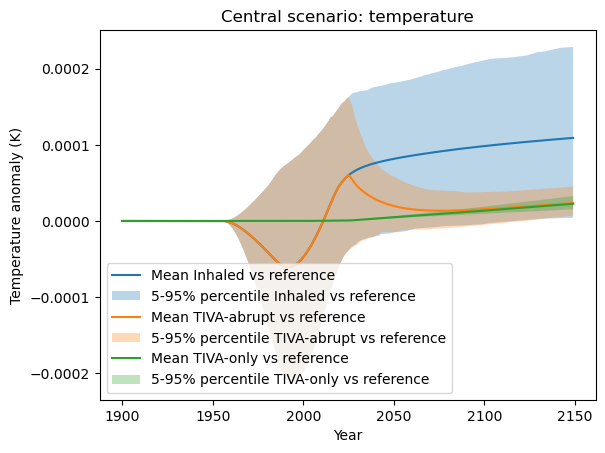

In [34]:
#Comparing temperature anomaly distribution of temperature increases for inhaled (business as usual) and TIVA-abrup scenarios
# Inhaled
plt.plot(time_np_inhaled[:250], mean_np_inhaled[:250], label='Mean Inhaled vs reference')
plt.fill_between(time_np_inhaled[:250], p05_inhaled[:250], p95_inhaled[:250], alpha=0.3, label='5-95% percentile Inhaled vs reference')

# TIVA abrupt change
plt.plot(time_np_tiva_abrupt_change[:250], mean_np_tiva_abrupt_change[:250], label='Mean TIVA-abrupt vs reference')
plt.fill_between(time_np_tiva_abrupt_change[:250], p05_tiva_abrupt_change[:250], p95_tiva_abrupt_change[:250], alpha=0.3, label='5-95% percentile TIVA-abrupt vs reference')

# TIVA only
plt.plot(time_np_tiva_only[:250], mean_np_tiva_only[:250], label='Mean TIVA-only vs reference')
plt.fill_between(time_np_tiva_only[:250], p05_tiva_only[:250], p95_tiva_only[:250], alpha=0.3, label='5-95% percentile TIVA-only vs reference')

plt.title('Central scenario: temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()

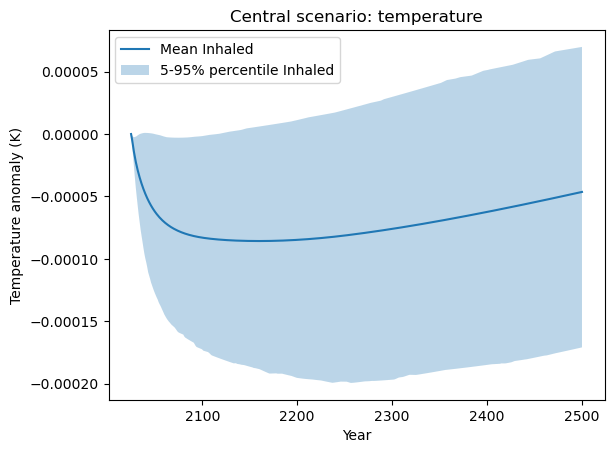

In [35]:
# Temperature anomaly between business as usual (inhaled) and abrupt TIVA 
# Slice the relevant part of the data
time_tiva_abrupt_change_vs_inhaled = simulation_timebounds[275:]
temp_tiva_abrupt_change_vs_inhaled = temp_ano_tiva_abrupt_change_vs_inhaled[275:]

# Compute mean and standard deviation over 'config'
mean_temp_tiva_abrupt_change_vs_inhaled = temp_tiva_abrupt_change_vs_inhaled.mean(dim='config')
std_temp_tiva_abrupt_change_vs_inhaled = temp_tiva_abrupt_change_vs_inhaled.std(dim='config')

# Convert to numpy for plotting
time_np_tiva_abrupt_change_vs_inhaled = time_tiva_abrupt_change_vs_inhaled
mean_np_tiva_abrupt_change_vs_inhaled = mean_temp_tiva_abrupt_change_vs_inhaled.values
std_np_tiva_abrupt_change_vs_inhaled = std_temp_tiva_abrupt_change_vs_inhaled.values

p05_tiva_abrupt_change_vs_inhaled = temp_tiva_abrupt_change_vs_inhaled.quantile(0.05, dim='config')
p95_tiva_abrupt_change_vs_inhaled = temp_tiva_abrupt_change_vs_inhaled.quantile(0.95, dim='config')

# Tiva-abrupt vs inhaled
plt.plot(time_np_tiva_abrupt_change_vs_inhaled, mean_np_tiva_abrupt_change_vs_inhaled, label='Mean Inhaled')
plt.fill_between(time_np_tiva_abrupt_change_vs_inhaled, p05_tiva_abrupt_change_vs_inhaled, p95_tiva_abrupt_change_vs_inhaled, alpha=0.3, label='5-95% percentile Inhaled')

plt.title('Central scenario: temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()

In [36]:
# Just a sanity check, run the anesthesics simulation but with anaesthesic emissions set to 0
f_anes_0 = FAIR()
f_anes_0.define_time(1750, 2500, 1)
f_anes_0.define_scenarios(scenarios)
f_anes_0.define_configs(configs)
species_anes_0, properties_anes_0 = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_anes_0.define_species(species_anes_0, properties_anes_0)
f_anes_0.allocate()
f_anes_0.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)]
fe = da.expand_dims(dim=["config"], axis=(2))
f_anes_0.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Load inhaled emissions, but set them at 0 after 2025
# Prepare the new emissions
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions.csv")

species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_0 = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_0[275:, :] = 0
emissions_1_0 = emissions_1_0[:, :, np.newaxis]
emissions_1_0 = np.repeat(emissions_1_0, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_0 = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_0[275:, :] = 0
emissions_2_0 = emissions_2_0[:, :, np.newaxis]
emissions_2_0 = np.repeat(emissions_2_0, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_0 = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_0[275:, :] = 0
emissions_3_0 = emissions_3_0[:, :, np.newaxis]
emissions_3_0 = np.repeat(emissions_3_0, len(configs), axis=2)

fill(f_anes_0.emissions, 0, specie="HFE-236ea2")
fill(f_anes_0.emissions, 0, specie="HFE-347mmz1")
fill(f_anes_0.emissions, 0, specie="HCFE-235da2")
fill(f_anes_0.emissions, 0, specie="Halon-2311")

# Add TIVA:
# 0.5 kg of plastic waster per intervention * 300 millions of interventions = 150 millions Kg of plastic waster
# ~3 Kg of CO2 emissions per Kg of plastic waster burned * 150 millions of kg of plastic waste = 450 millions of CO2 = 0.00045 GtC
TIVA_emissions = np.zeros(750)
TIVA_emissions[275:] = 4.5 * 0.0001

# f_anes_0.emissions.loc[dict(specie='CO2 FFI')] = f_anes_0.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions[:, np.newaxis, np.newaxis]

f_anes_0.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
initialise(f_anes_0.concentration, f_anes_0.species_configs["baseline_concentration"])
initialise(f_anes_0.forcing, 0)
initialise(f_anes_0.temperature, 0)
initialise(f_anes_0.cumulative_emissions, 0)
initialise(f_anes_0.airborne_emissions, 0)
f_anes_0.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_anes_0.run()

temp_ano_anes_0 = f_anes_0.temperature.loc[dict(scenario=scenario_to_compare, layer=0)] - f_no_anesthesics_temperature.loc[dict(scenario=scenario_to_compare)]

del f_anes_0

Running 2523 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

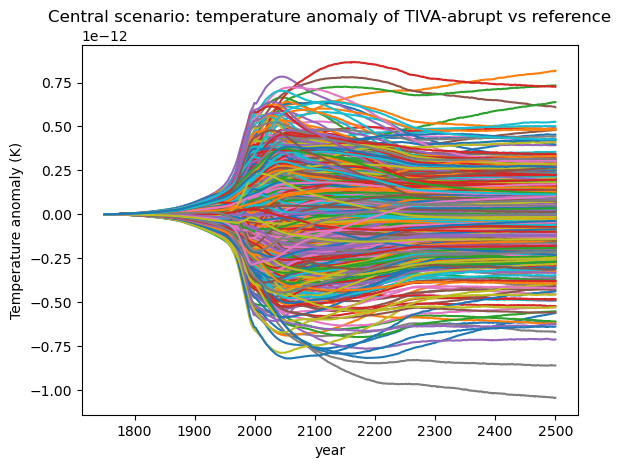

In [37]:
# Same plots as before but for T

plt.plot(simulation_timebounds, temp_ano_anes_0[:])
plt.title('Central scenario: temperature anomaly of TIVA-abrupt vs reference')
plt.xlabel('year')
plt.ylabel('Temperature anomaly (K)')
plt.show()